### Linear regression model

As a first try, we shall create a linear regression model and try to do predictions

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics


In [2]:
dfp = pd.read_csv('./data/processed.csv')
dfp.head()

,drp_rnd_long,drp_rnd_lat,pickup_weekday,pickup_hrmi,avg_distance,trips_count
0,-121.93,37.39,2,18.25,0.021824,1
1,-121.93,37.39,4,13.75,0.014827,1
2,-80.36,42.09,3,18.25,85.979240,1
3,-79.82,38.96,3,13.50,546.453239,1
4,-79.79,40.92,6,21.00,104.875073,1


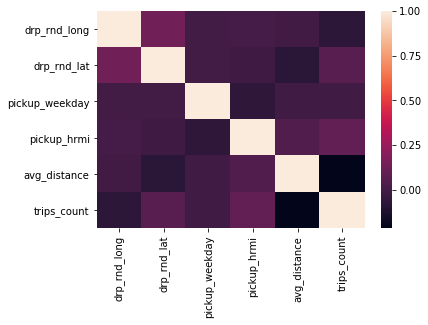

In [3]:
sns.heatmap(dfp.corr())

The above heatmap shows that the features are not colinear among themselfs. But we also see that there is not much correlation exists with the target variable (trips_count) which might not be good for the purpose of prediction.

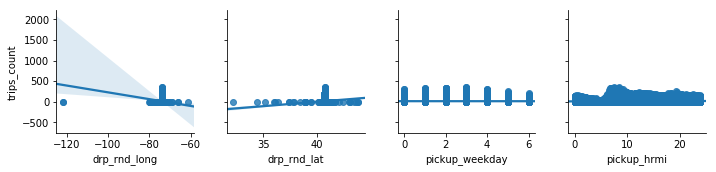

In [4]:
sns.pairplot(dfp, x_vars=['drp_rnd_long','drp_rnd_lat','pickup_weekday','pickup_hrmi'], y_vars='trips_count', kind='reg')

#### Create dummies for weekday column as it is categorical

In [5]:
dfdum = pd.get_dummies(dfp.pickup_weekday, prefix='week').drop('week_0', axis=1)
dfp = pd.concat([dfp,dfdum], axis=1)

In [6]:
dfp.head()

,drp_rnd_long,drp_rnd_lat,pickup_weekday,pickup_hrmi,avg_distance,trips_count,week_1,week_2,week_3,week_4,week_5,week_6
0,-121.93,37.39,2,18.25,0.021824,1,0,1,0,0,0,0
1,-121.93,37.39,4,13.75,0.014827,1,0,0,0,1,0,0
2,-80.36,42.09,3,18.25,85.979240,1,0,0,1,0,0,0
3,-79.82,38.96,3,13.50,546.453239,1,0,0,1,0,0,0
4,-79.79,40.92,6,21.00,104.875073,1,0,0,0,0,0,1


#### We use LinearRegression model to fit and do a cross validation with k=10

In [7]:
X = dfp[['drp_rnd_long','drp_rnd_lat','pickup_hrmi','week_1','week_2','week_3','week_4','week_5', 'week_6']]
y = dfp['trips_count']

In [8]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=10)

In [9]:
print (lr_scores)

[-9.46209509e+00 -2.40635358e-01 -2.33726492e-01  6.42046971e-03
  3.85228361e-02  1.56747483e-02 -2.43782960e+01 -5.64377175e+01
 -4.32738280e+00 -2.78054007e+01]


We see that most of the scores are negative, indicating the model performs worse.


In any case, we shall proceed with a train test split and check errors in predictions

###### Do a single train test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

26.829107457476027


###### Compare with a null RMSE

y_pred

In [12]:
y_null = np.zeros_like(y_test, dtype=float)
y_null.fill(y_test.mean())
y_null

array([12.58111935, 12.58111935, 12.58111935, ..., 12.58111935,
       12.58111935, 12.58111935])

In [13]:
np.sqrt(metrics.mean_squared_error(y_test, y_null))

27.162845138090184

##### The RMSE for the linear regression model is only slightly better than NULL rmse.

#### Let us test it with other regression models



In [14]:
def fit_and_predict(rgr, name):
    rgr.fit(X_train,y_train)
    y_pred = rgr.predict(X_test)
    print (name, ':', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ("Null:", np.sqrt(metrics.mean_squared_error(y_test, y_null)))
    

In [15]:
fit_and_predict(LinearRegression(), 'Linear Regression')

Linear Regression : 26.829107457476027
Null: 27.162845138090184


In [16]:
from sklearn.svm import SVR
fit_and_predict(SVR(), 'Support Vector Regression')

Support Vector Regression : 28.769528109433622
Null: 27.162845138090184


#### The SVR peformance badly. But as it is recommended to scale the data for SVR, we first use scaler

In [17]:
def split_fit_and_predict(X, y, rgr, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    rgr.fit(X_train,y_train)
    y_pred = rgr.predict(X_test)
    print (name, ':', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ("Null:", np.sqrt(metrics.mean_squared_error(y_test, y_null)))

In [18]:
X.head()

,drp_rnd_long,drp_rnd_lat,pickup_hrmi,week_1,week_2,week_3,week_4,week_5,week_6
0,-121.93,37.39,18.25,0,1,0,0,0,0
1,-121.93,37.39,13.75,0,0,0,1,0,0
2,-80.36,42.09,18.25,0,0,1,0,0,0
3,-79.82,38.96,13.50,0,0,1,0,0,0
4,-79.79,40.92,21.00,0,0,0,0,0,1


In [19]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [20]:
Xs

array([[-2.13427727e+02, -3.97960428e+01,  7.82477039e-01, ...,
        -4.15832474e-01, -4.22863812e-01, -4.25961713e-01],
       [-2.13427727e+02, -3.97960428e+01,  1.73470519e-01, ...,
         2.40481459e+00, -4.22863812e-01, -4.25961713e-01],
       [-2.85543555e+01,  1.60438106e+01,  7.82477039e-01, ...,
        -4.15832474e-01, -4.22863812e-01, -4.25961713e-01],
       ...,
       [ 3.57532931e+01, -1.52027456e+01,  5.79474866e-01, ...,
        -4.15832474e-01, -4.22863812e-01,  2.34762883e+00],
       [ 3.59756570e+01, -7.57949269e+01,  1.05314660e+00, ...,
        -4.15832474e-01, -4.22863812e-01, -4.25961713e-01],
       [ 5.60328836e+01, -3.43308656e+01,  5.79474866e-01, ...,
         2.40481459e+00, -4.22863812e-01, -4.25961713e-01]])

In [21]:
split_fit_and_predict(X, y, LinearRegression(), 'Linear Regression')

Linear Regression : 26.829107457476027
Null: 27.162845138090184


In [22]:
split_fit_and_predict(Xs, y, LinearRegression(), 'Linear Regression')

Linear Regression : 26.82910745747603
Null: 27.162845138090184


In [23]:
split_fit_and_predict(Xs, y, SVR(), 'Support Vector Regression with scale')

Support Vector Regression with scale : 27.603133033032044
Null: 27.162845138090184


#### Scaling has reduced RMSE for SVR but still it is not better then NULL RMSE

In [25]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118637 entries, 0 to 118636
Data columns (total 12 columns):
drp_rnd_long      118637 non-null float64
drp_rnd_lat       118637 non-null float64
pickup_weekday    118637 non-null int64
pickup_hrmi       118637 non-null float64
avg_distance      118637 non-null float64
trips_count       118637 non-null int64
week_1            118637 non-null uint8
week_2            118637 non-null uint8
week_3            118637 non-null uint8
week_4            118637 non-null uint8
week_5            118637 non-null uint8
week_6            118637 non-null uint8
dtypes: float64(4), int64(2), uint8(6)
memory usage: 7.0 MB


In [26]:
dfp[(dfp['drp_rnd_long'] == -73.99) & (dfp['drp_rnd_lat'] == 40.75)].head()

,drp_rnd_long,drp_rnd_lat,pickup_weekday,pickup_hrmi,avg_distance,trips_count,week_1,week_2,week_3,week_4,week_5,week_6
23015,-73.99,40.75,0,0.00,2.816088,48,0,0,0,0,0,0
23016,-73.99,40.75,0,0.25,2.826471,44,0,0,0,0,0,0
23017,-73.99,40.75,0,0.50,3.022109,40,0,0,0,0,0,0
23018,-73.99,40.75,0,0.75,3.152924,42,0,0,0,0,0,0
23019,-73.99,40.75,0,1.00,2.473090,34,0,0,0,0,0,0


#### We conculde that linear regression models are not performing to our expectation. We can try other models

As there are time components involved in our dataset, we can resort to Time Series models